# Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [2]:
!which python

/Applications/anaconda3/envs/py36/bin/python


# Install dependencies:

In [3]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

# Imports

In [4]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [5]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [7]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [8]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [9]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [10]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.52927643
n_clusters: 3 silhouette_avg: 0.37249258
n_clusters: 4 silhouette_avg: 0.34731567
n_clusters: 5 silhouette_avg: 0.36717007
n_clusters: 6 silhouette_avg: 0.33484617
n_clusters: 7 silhouette_avg: 0.35775205
n_clusters: 8 silhouette_avg: 0.33568233
n_clusters: 9 silhouette_avg: 0.30858207
n_clusters: 10 silhouette_avg: 0.27952528
n_clusters: 11 silhouette_avg: 0.3005465
n_clusters: 12 silhouette_avg: 0.28711826
n_clusters: 13 silhouette_avg: 0.29334292
n_clusters: 14 silhouette_avg: 0.28563792
n_clusters: 15 silhouette_avg: 0.2851835
n_clusters: 16 silhouette_avg: 0.28127608
n_clusters: 17 silhouette_avg: 0.28606513
n_clusters: 18 silhouette_avg: 0.29453495
n_clusters: 19 silhouette_avg: 0.29737058
n_clusters: 20 silhouette_avg: 0.28984872
n_clusters: 21 silhouette_avg: 0.29293966
n_clusters: 22 silhouette_avg: 0.29010648
n_clusters: 23 silhouette_avg: 0.29417247
n_clusters: 24 silhouette_avg: 0.30307212
n_clusters: 25 silhouette_avg: 0.31331077
n_

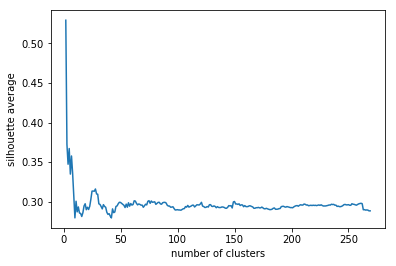

In [60]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2
max_clusters=270
step=1

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [70]:
number_of_clusters =  28
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 14     21
18     43
2      72
12     91
25    100
8     102
20    108
9     123
23    124
21    124
4     132
26    134
27    141
0     143
13    144
19    150
22    150
15    152
7     156
24    156
1     168
17    183
6     185
11    197
5     208
16    230
10    246
3     252
Name: label_kmedoids, dtype: int64


In [71]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [72]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/Applications/anaconda3/envs/py36/lib/python3.6/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

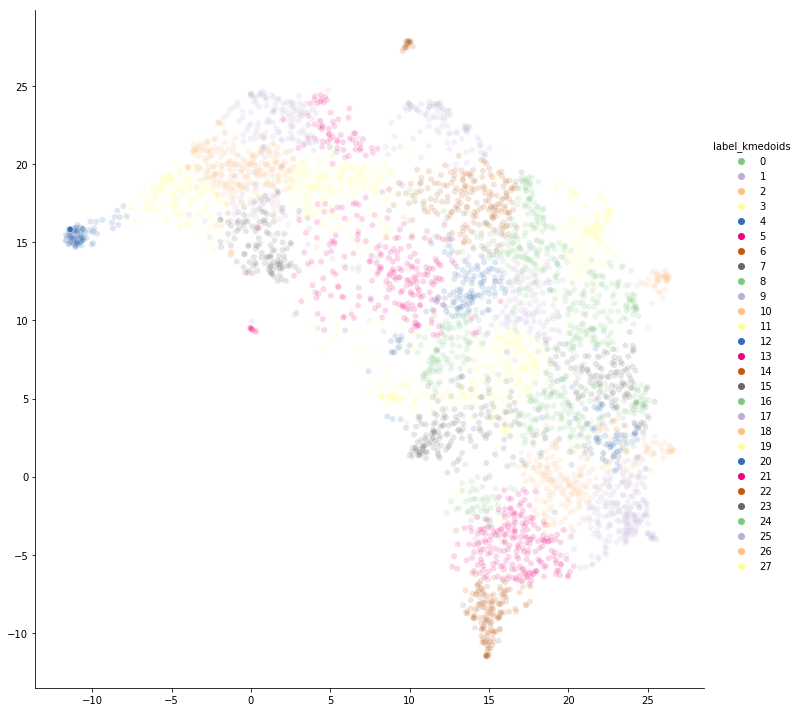

In [73]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

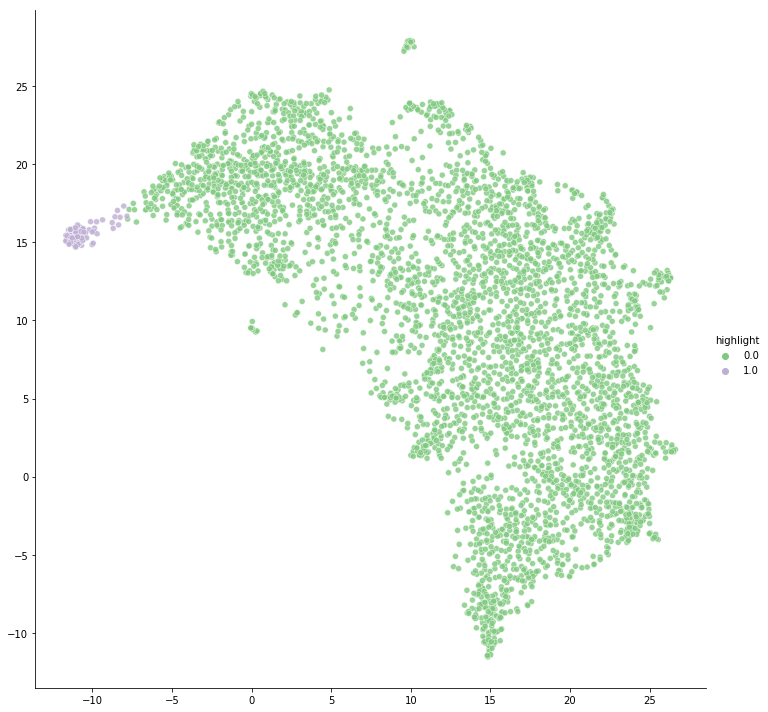

In [106]:
## Choose a cluster to higlight:
cluster_num = 4

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [107]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
2608,2019-04-29 18:27:14,Doug Steeves,"Hey Boston Globe. What Is this man&#39;s science? It obviously isn&#39;t climate science. The doubts in the data that he brings up have already been addressed years ago. Also his statement that the climate has always changed, while true, misses the point. It&#39;s not that climate is changing but how quickly it is now changing that makes scientists question whether ecosystems can adapt.",0,"Hey Boston Globe. What Is this man's science? It obviously isn't climate\nscience. The doubts in the data that he brings up have already been addressed\nyears ago. Also his statement that the climate has always changed, while true,\nmisses the point. It's not that climate is changing but how quickly it is now\nchanging that makes scientists question whether ecosystems can adapt.\n\n",-1,0,0.000000e+00,0.0
100,2020-05-30 17:09:16,Evan Romito,What the fuck is this shithead talking about,0,What the fuck is this shithead talking about\n\n,-1,1,5.960464e-08,0.0
3638,2018-12-25 09:50:33,Roger Diogo,"@SwiftlyTiltingPlanet Krakatoa and Mount Etna just erupted, further proof than we are living in a grand solar minimum, now if Vesuvius goes next, that will be the nail in the coffin, cold temperature records are being felt all over the World as I wright this, and the inquisition of the 21st century has been bury those temperatures...Just telling you, the argumente you´re using clergy use it during the last grand solar minimum too!",1,"@ Krakatoa and Mount Etna just erupted, further proof than\nwe are living in a grand solar minimum, now if Vesuvius goes next, that will\nbe the nail in the coffin, cold temperature records are being felt all over\nthe World as I wright this, and the inquisition of the 21st century has been\nbury those temperatures...Just telling you, the argumente you´re using clergy\nuse it during the last grand solar minimum too!\n\n",-1,2,1.788139e-07,0.0
393,2019-11-08 20:34:29,Kev Tea,I won&#39;t fear climate fluctuations like left wing dipshits that think government politicians have great solutions to saving Greta&#39;s life.,0,I won't fear climate fluctuations like left wing dipshits that think\ngovernment politicians have great solutions to saving Greta's life.\n\n,-1,3,1.192093e-07,0.0
3315,2019-04-25 21:32:32,szililolabu,@Anthony Matthews arrant.,1,@ arrant.\n\n,-1,4,0.000000e+00,1.0
2290,2019-08-27 19:44:31,jeff westbrooke,"@Daniel Ferra dude I never named called, i said it was the stupidest thing you've said. Or was that just the excuse you want to use to get out of the conversation? And seriously are you that stupid (now i name called). There is plenty of data to support my position just like plenty of data to support your position. Look for it your self but also do research. The recent NOAA article was scary but lots of false info. They said midwest was warmer than average but it's wrong, midwest was colder. Mildest summer I remember. Not a single day over 100°. NOAA said Brazil was warmer than average but it was wrong because I researched actual recorded temperature vs. Historical averages. NOAA lied to get more of the $14B annual funding. Please research it yourself rather than just believing it. Lots of scientists say lots of things. Climate change doesn't = science. The consensus was a lie as well. Please find me the names of those 97% of scientists. I trust climatologist like judith curry and meteorologists like Joe bastardi and the gentleman in this video. Not to mention the Nobel laureates that agree. Research medieval warm period when earth had lower co2 and much higher temps.",1,"@ dude I never named called, i said it was the stupidest thing\nyou've said. Or was that just the excuse you want to use to get out of the\nconversation? And seriously are you that stupid (now i name called). There is\nplenty of data to support my position just like plenty of data to support your\npos

In [108]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  143 mean distance from center:  0.00483560397697147 Proportion of replies: 44.75524475524475
1 number of samples:  168 mean distance from center:  0.003844535240205005 Proportion of replies: 53.57142857142857
2 number of samples:  72 mean distance from center:  0.0025711125999805517 Proportion of replies: 77.77777777777777
3 number of samples:  252 mean distance from center:  0.006754294008715078 Proportion of replies: 42.857142857142854
4 number of samples:  132 mean distance from center:  0.0005960916041658493 Proportion of replies: 71.21212121212122
5 number of samples:  208 mean distance from center:  0.003658750938484445 Proportion of replies: 77.40384615384616
6 number of samples:  185 mean distance from center:  0.005094296284369193 Proportion of replies: 71.89189189189189
7 number of samples:  156 mean distance from center:  0.004026943133794703 Proportion of replies: 71.15384615384616
8 number of samples:  102 mean distance from center:  0.003769117392948

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [109]:
# Choose a cluster to print
cluster_number =   4
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 132
Average Distance from cluster center: 5.960916e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
2875,2019-05-02 11:53:02,408Magenta,@dasGagaTier Bullshit!!,1,@ Bullshit!!\n\n,-1,4,0.000000e+00,1.0
3315,2019-04-25 21:32:32,szililolabu,@Anthony Matthews arrant.,1,@ arrant.\n\n,-1,4,0.000000e+00,1.0
2303,2019-05-07 14:43:24,Wayne Ballintine,@Zarion 11 Bullshit,1,@ Bullshit\n\n,-1,4,0.000000e+00,1.0
619,2019-10-11 11:41:16,Philipp Kummer,bullshit,0,bullshit\n\n,-1,4,0.000000e+00,1.0
2617,2019-04-29 07:49:44,Staffan Goldschmidt,Bullshit!,0,Bullshit!\n\n,-1,4,0.000000e+00,1.0
3862,2019-04-13 20:38:51,jar josh,@SwiftlyTiltingPlanet https://www.nasa.gov/feature/goddard/nasa-study-mass-gains-of-antarctic-ice-sheet-greater-than-losses/,1,@ \ngains-of-antarctic-ice-sheet-greater-than-losses/\n\n,-1,4,1.192093e-07,1.0
984,2019-09-30 07:07:05,Bonga Zulu,😂😂😂😂,1,😂😂😂😂\n\n,-1,4,2.384186e-07,1.0
3004,2019-04-25 23:53:00,GrapeJamHard,"<a href=""https://www3.bostonglobe.com/metro/2017/03/08/mit-professors-denounce-their-colleague-letter-trump-for-denying-evidence-climate-change/86K8ur31YIUbMO4SAI7U2N/story.html?arc404=true"">https://www3.bostonglobe.com/metro/2017/03/08/mit-professors-denounce-their-colleague-letter-trump-for-denying-evidence-climate-change/86K8ur31YIUbMO4SAI7U2N/story.html?arc404=true</a>",0,\ncolleague-letter-trump-for-denying-evidence-climate-\nchange/86K8ur31YIUbMO4SAI7U2N/story.html?arc404=true\n\n,-1,4,2.980232e-07,1.0
1657,2019-05-19 11:35:42,Jacques Auger,"<a href=""https://www3.bostonglobe.com/metro/2017/03/08/mit-professors-denounce-their-colleague-letter-trump-for-denying-evidence-climate-change/86K8ur31YIUbMO4SAI7U2N/story.html?arc404=true"">https://www3.bostonglobe.com/metro/2017/03/08/mit-professors-denounce-their-colleague-letter-trump-for-denying-evidence-climate-change/86K8ur31YIUbMO4SAI7U2N/story.html?arc404=true</a>",0,\ncolleague-letter-trump-for-denying-evidence-climate-\nchange/86K8ur31YIUbMO4SAI7U2N/story.html?arc404=true\n\n,-1,4,2.980232e-07,1.0
3316,2019-04-25 21:21:13,Anthony Matthews,@szililolabu Like?,1,@ Like?\n\n,-1,4,4.172325e-07,1.0


# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [104]:
#which cluster would you like to assign labels to?
cluster_number = 14
#your label
label_manual = 'elections'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [105]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
3387,2019-04-27 16:14:14,Hellstrom Carbunkle,"@Roger didit Wrong, I trusted the Polling when it said, after Comey, Hillary by 3% It WAS Hillary by 3% Weren't you reading?",1,"@ Wrong, I trusted the Polling when it said, after Comey, Hillary\nby 3% It WAS Hillary by 3% Weren't you reading?\n\n",elections,14,0.000000e+00,1.0
3351,2019-04-30 18:02:50,Hellstrom Carbunkle,"@Roger didit I gave you the polls. They said Hillary by 3% She was elected by 3% MORE of the people. Simple, you lied. 303 is not a landslide, btw. Obama had two landslides",1,"@ I gave you the polls. They said Hillary by 3% She was elected by\n3% MORE of the people. Simple, you lied. 303 is not a landslide, btw. Obama\nhad two landslides\n\n",elections,14,0.000000e+00,1.0
3371,2019-04-28 20:34:40,Roger didit,"@Hellstrom Carbunkle Can you read? Do you understand what you read? I give you the facts. I give you the links that show those facts. In addition I explain to you that there are THREE WAYS to produce an ""average"".. Then to sum it up I give you what the POLLSTERS EXPECTED from the numbers on election night. Clearly stated, with a link for you to read it. Hilary was due to win in a landslide. READ what they expected from the electoral college. COMPARE that with the ACTUAL results. Discussion is over.",1,"@ Can you read? Do you understand what you read? I give you\nthe facts. I give you the links that show those facts. In addition I explain\nto you that there are THREE WAYS to produce an ""average"".. Then to sum it up I\ngive you what the POLLSTERS EXPECTED from the numbers on election night.\nClearly stated, with a link for you to read it. Hilary was due to win in a\nlandslide. READ what they expected from the electoral college. COMPARE that\nwith the ACTUAL results. Discussion is over.\n\n",elections,14,0.000000e+00,1.0
3370,2019-04-28 21:09:57,Hellstrom Carbunkle,"@Roger didit No, gave YOU the facts. EVERY, repeat that, EVERY reliable poll said, after Comey cut her lead by 62%, Hillary by 3% She won the vote by 3%. Nice try liar, but when Comey changed the subject, EVERYONE for that last two weeks knew it would be 3+-1%.",1,"@ No, gave YOU the facts. EVERY, repeat that, EVERY reliable poll\nsaid, after Comey cut her lead by 62%, Hillary by 3% She won the vote by 3%.\nNice try liar, but when Comey changed the subject, EVERYONE for that last two\nweeks knew it would be 3+-1%.\n\n",elections,14,0.000000e+00,1.0
3364,2019-04-29 22:04:46,Roger didit,"@Hellstrom Carbunkle Yeah, I see the dates. I saw them at the beginning of the argument. You're just TOO STUPID to read the polls. One says six points, another says five, a few say three. The AVERAGE is three. WHO CARES ABOUT AVERAGE? When two boxers go in the ring, do they ask what the AVERAGE boxers record is? Duh! Here's the bottom line.. WHO WAS LEADING? CLINTON. WHO WON BY A FIFTY PERCENT DIFFERENCE IN ELECTORAL COLLEGE POINTS? TRUMP! Now California could have 90% more votes for Hillary dummy. Does it make it a BLUER STATE? DUH!! But Retard Carbunkle is giving us the AVERAGE poll!! Barahahaha.. What a dope!! California can have 50 million more votes for Hillary. Does that win the election? You have an IQ of about 80.. I'm telling you. You have a right to be stupid, but you ABUSE that right.",1,"@ Yeah, I see the dates. I saw them at the beginning of the\nargument. You're just TOO STUPID to read the polls. One says six points,\nanother says five, a few say three. The AVERAGE is three. WHO CARES ABOUT\nAVERAGE? When two boxers go in the ring, do they ask what the AVERAGE boxers\nrecord is? Duh! Here's the bottom line.. WHO WAS LEADING? CLINTON. WHO WON BY\nA FIFTY PERCENT DIFFERENCE IN ELECTORAL COLLEGE POINTS? TRUMP! Now California\ncould have 90% more votes for Hillary dummy. Does it make it a BLUER STATE?\nDUH!! But Retard Carbunkle is giving us the AVERAGE poll!! Barahahaha.. What a\ndope!! California can h